In [ ]:
!pip install psycopg
!pip install ta

In [ ]:
import pandas as pd
import numpy as np
import psycopg
import math
import ta

from math import floor
from matplotlib import pyplot as plt

## 1 Prepare the Data

### 1.1 Loading Data from AlgotradeDB

In [ ]:
db_info = {
    "host": "api.algotrade.vn",
    "port": 5432,
    "database": "algotradeDB",
    "user": "intern_read_only",
    "password": "ZmDaLzFf8pg5"
}

# Open a connection using with statement
with psycopg.connect(
    host=db_info['host'],
    port=db_info['port'],
    dbname=db_info['database'],
    user=db_info['user'],
    password=db_info['password']
) as conn:

    query = """
        SELECT tb_max.datetime AS datetime,
        tb_max.tickersymbol AS tickersymbol,
        tb_open.price AS "Open",
        tb_max.price AS "High",
        tb_min.price AS "Low",
        tb_close.price AS "Close"

        FROM (
            SELECT *
            FROM quote.max
        ) tb_max
        INNER JOIN (
            SELECT *
            FROM quote.min
        ) tb_min
        ON tb_max.tickersymbol = tb_min.tickersymbol AND tb_max.datetime = tb_min.datetime
        INNER JOIN (
            SELECT *
            FROM quote.close
        ) tb_close
        ON tb_min.tickersymbol = tb_close.tickersymbol AND tb_min.datetime = tb_close.datetime
        INNER JOIN (
            SELECT *
            FROM quote.open
        ) tb_open
        ON tb_open.tickersymbol = tb_close.tickersymbol AND tb_open.datetime = tb_close.datetime

        WHERE tb_open.tickersymbol LIKE 'VN30F%' AND tb_open.datetime BETWEEN
    """

    in_sample_date = "'2021-01-01' AND '2023-01-01'"
    out_sample_date = "'2023-01-01' AND '2024-01-01'"

    in_sample_data = pd.read_sql_query(query + in_sample_date, conn)
    out_sample_data = pd.read_sql_query(query + out_sample_date, conn)

<ipython-input-34-9056db49e6ae>:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  in_sample_data = pd.read_sql_query(query + in_sample_date, conn)
<ipython-input-34-9056db49e6ae>:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  out_sample_data = pd.read_sql_query(query + out_sample_date, conn)


In [ ]:
print(in_sample_data.shape)
print(out_sample_data.shape)
print(in_sample_data.drop_duplicates(subset='datetime').shape)

(1996, 6)
(996, 6)
(499, 6)


In [ ]:
in_sample_data.head(10)

,datetime,tickersymbol,Open,High,Low,Close
0,2021-01-04,VN30F2102,1090.0,1115.0,1090.0,1112.6
1,2021-01-05,VN30F2102,1110.0,1116.9,1100.0,1113.4
2,2021-01-04,VN30F2103,1093.9,1112.7,1093.8,1109.8
3,2021-01-06,VN30F2102,1116.6,1135.0,1116.5,1126.3
4,2021-01-05,VN30F2103,1100.7,1116.0,1100.7,1113.9
5,2021-01-07,VN30F2102,1138.7,1149.5,1127.0,1149.5
6,2021-01-06,VN30F2103,1118.8,1132.3,1117.5,1127.0
7,2021-01-08,VN30F2102,1147.9,1179.0,1147.9,1179.0
8,2021-01-07,VN30F2103,1138.6,1148.0,1127.9,1145.5
9,2021-01-11,VN30F2102,1185.0,1200.0,1179.4,1200.0


### 1.2 Data Preprocessing

In [ ]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:

    def third_thursdays(year):
        third_thursdays_list = []
        for month in range(1, 13):
            # Find the first day of the month
            first_day = pd.Timestamp(year, month, 1)
            # Find the first Thursday of the month
            first_thursday = first_day + pd.Timedelta(days = (3 - first_day.weekday() + 7) % 7)
            # Calculate the third Thursday
            third_thursday = first_thursday + pd.Timedelta(weeks = 2)
            third_thursdays_list.append(third_thursday)
        return third_thursdays_list

    third_thursdays_list = []
    for i in range(2020, 2025):
        third_thursdays_list.append(third_thursdays(i))

    data['datetime'] = pd.to_datetime(data['datetime'])

    def filterData(row):
        year = int(row['tickersymbol'][5:7]) + 2000
        month = int(row['tickersymbol'][7:9])
        date = pd.Timestamp(year, month, 1)
        if date > pd.Timestamp(2024, 1, 1) or date < pd.Timestamp(2021, 1, 1):
            return False
        ticker_start = third_thursdays_list[year - 2020][month - 2] if month > 1 else third_thursdays_list[year - 2021][11]
        ticker_start += pd.Timedelta(days = 1)
        ticker_end = third_thursdays_list[year - 2020][month - 1]
        return ticker_start <= row['datetime'] <= ticker_end

    data = data[data.apply(lambda row: filterData(row), axis=1)]

    return data.sort_values('datetime').dropna().drop_duplicates()

In [ ]:
in_sample_data = preprocess(in_sample_data)
out_sample_data = preprocess(out_sample_data)
in_sample_data.reset_index(drop = True, inplace = True)
out_sample_data.reset_index(drop = True, inplace = True)
print(in_sample_data.shape)
print(out_sample_data.shape)

(499, 6)
(249, 6)


In [ ]:
in_sample_data.head(10)

,datetime,tickersymbol,Open,High,Low,Close
0,2021-01-04,VN30F2101,1091.0,1115.0,1090.2,1109.4
1,2021-01-05,VN30F2101,1106.5,1115.7,1100.1,1111.0
2,2021-01-06,VN30F2101,1116.5,1132.5,1114.1,1125.0
3,2021-01-07,VN30F2101,1134.8,1148.9,1124.2,1148.9
4,2021-01-08,VN30F2101,1146.7,1176.6,1146.0,1176.6
5,2021-01-11,VN30F2101,1180.9,1196.8,1177.2,1193.1
6,2021-01-12,VN30F2101,1197.9,1198.0,1184.2,1191.9
7,2021-01-13,VN30F2101,1195.0,1201.6,1179.0,1192.0
8,2021-01-14,VN30F2101,1190.8,1195.6,1182.0,1188.9
9,2021-01-15,VN30F2101,1191.3,1194.9,1188.1,1190.5


### 1.3 Data Visualization

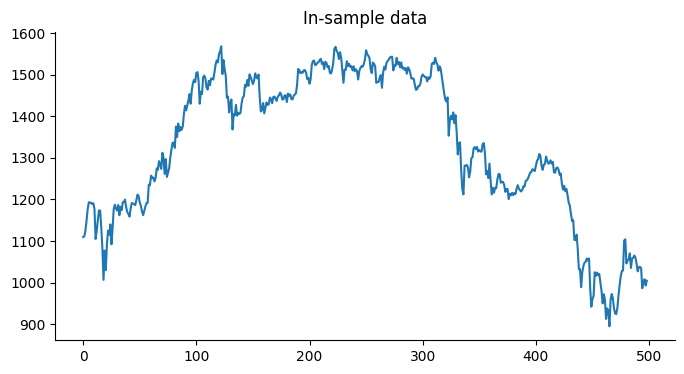

In [ ]:
in_sample_data['Close'].plot(kind='line', figsize=(8, 4), title='In-sample data')
plt.gca().spines[['top', 'right']].set_visible(False)

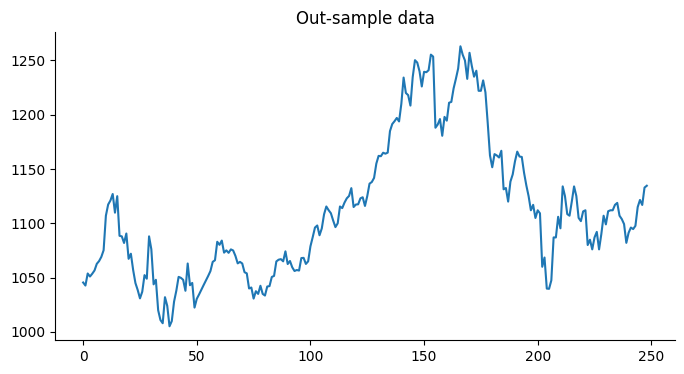

In [ ]:
out_sample_data['Close'].plot(kind='line', figsize=(8, 4), title='Out-sample data')
plt.gca().spines[['top', 'right']].set_visible(False)

We will use the `Close` price to run the `SMA Algorithm` later on

In [ ]:
# Copy the in-sample data to another data
data = in_sample_data.copy()
data['Close']

,Close
0,1109.4
1,1111.0
2,1125.0
3,1148.9
4,1176.6
...,...
494,986.4
495,1001.0
496,1008.0
497,993.0


## 2 The SMA (Simple Moving Average) Algorithm

### 2.1 SMA Visualization

In [ ]:
# TODO: adjust SMA_WINDOW_LENGTH to optimize algorithm (in in-sample data set only)
SMA_WINDOW_LENGTH = 30
SMA_SYMBOL = f'SMA-{SMA_WINDOW_LENGTH}'
TICKER_SYMBOL = 'VN30F1M'

data[SMA_SYMBOL] = data['Close'].rolling(SMA_WINDOW_LENGTH).mean()

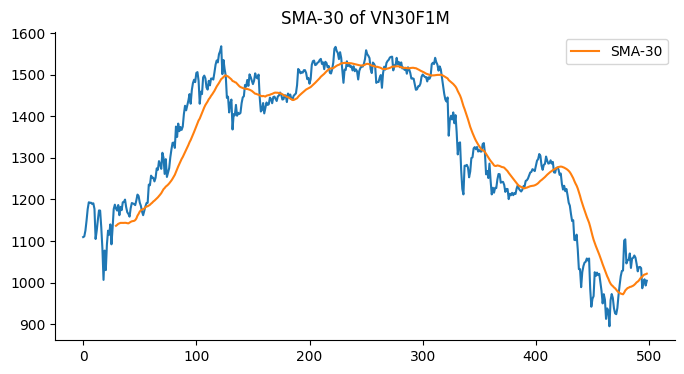

In [ ]:
# Plot SMA on top of the Close price
fig = plt.figure()
ax = fig.add_subplot(111)
data['Close'].plot(kind='line', figsize=(8, 4), title=f'SMA-{SMA_WINDOW_LENGTH} of {TICKER_SYMBOL}', ax=ax)
data[SMA_SYMBOL].plot(kind='line', figsize=(8, 4), ax=ax, legend=True)
plt.gca().spines[['top', 'right']].set_visible(False)

### 2.2 Algorithm Configuration

In [ ]:
# SMA_WINDOW_LENGTH = 30
ASSET_VALUE = 10000
# Constants
FAST_EMA_WINDOW = 5
SLOW_EMA_WINDOW = 20
EMA_SIGNAL_WINDOW = 5
RSI_WINDOW = 8
ATR_WINDOW = 10
ATR_MULTIPLIER = 2
TAX = 0.47

In [ ]:
def algo(data: pd.DataFrame) -> pd.DataFrame:
    """
    Implements an improved trading algorithm using EMA, RSI, and ATR.

    Parameters:
    - data: DataFrame with columns 'datetime', 'High', 'Low', 'Close'

    Returns:
    - trading_data: DataFrame with asset value history and technical indicators
    """

    # Prepare data
    data = data.copy()
    data.set_index('datetime', inplace=True)

    # Initialize trading variables
    cash = ASSET_VALUE
    holdings = []  # List of (entry_date, pos_type, entry_price, quantity)
    trading_data = data.copy()
    trading_data['Asset'] = pd.NaN

    # Calculate technical indicators
    data['MACD'] = ta.trend.macd(data['close'], window_slow = SLOW_EMA_WINDOW, window_fast = FAST_EMA_WINDOW)
    data['MACD_signal'] = ta.trend.macd_signal(data['Close'], window_slow = SLOW_EMA_WINDOW, window_fast = FAST_EMA_WINDOW, window_sign = EMA_SIGNAL_WINDOW)
    data['RSI'] = ta.momentum.rsi(data['Close'], window = RSI_WINDOW)
    data['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = ATR_WINDOW)

    # Trading loop starting from the second day
    for i in range(1, len(data)):
        row = data.iloc[i]
        prev_row = data.iloc[i - 1]
        date = data.index[i]
        cur_price = row['Close']

        # Check for positions to close
        positions_to_close = []
        for position in holdings:
            entry_date, pos_type, entry_price, quantity, stop_loss_price, take_profit_price = position

            if pos_type == 'LONG':
                if cur_price >= take_profit_price or cur_price <= stop_loss_price or row['RSI'] >= 70:
                    # Closing a LONG position (selling)
                    cash += quantity * cur_price - quantity * TAX
                    holdings.remove(position)
            else:  # SHORT
                if cur_price <= take_profit_price or cur_price >= stop_loss_price or row['RSI'] <= 30:
                    # Closing a SHORT position (buying back)
                    cost = quantity * cur_price + quantity * TAX
                    cash -= cost
                    holdings.remove(position)

        # Calculate unrealized P&L and update asset value
        total_unrealized_pnf = sum(cur_price * pos[3] if pos[1] == 'LONG' else -cur_price * pos[3] for pos in holdings)
        asset_value = cash + total_unrealized_pnf
        trading_data.loc[date, 'Asset'] = asset_value

        # Open new position if no holdings
        if not holdings:

            # LONG position entry conditions
            if row['MACD'] > row['MACD_signal'] and 50 < row['RSI'] < 70:
                # Use half of cash, accounting for TAX
                quantity = math.floor((cash / 2) / (cur_price + TAX))
                if quantity > 0:
                    cash -= quantity * cur_price
                    stop_loss_price = cur_price - row['ATR'] * ATR_MULTIPLIER
                    take_profit_price = cur_price * (1 + TAKE_PROFIT_PERCENT)
                    holdings.append(date, 'LONG', cur_price, quantity, stop_loss_price, take_profit_price)

            # SHORT position entry conditions
            elif row['MACD'] < row['MACD_signal'] and 30 < row['RSI'] < 50:
                # Use half of cash to determine quantity
                quantity = math.floor((cash / 2) / cur_price)
                if quantity > 0:
                    total_proceeds = quantity * cur_price
                    cash += total_proceeds
                    stop_loss_price = cur_price + cur_atr * ATR_MULTIPLIER
                    take_profit_price = cur_price * (1 - TAKE_PROFIT_PERCENT)
                    holdings.append(date, 'SHORT', cur_price, quantity, stop_loss_price, take_profit_price)

    # Drop rows with NaN values (initial periods where indicators are not calculated)
    trading_data = trading_data.dropna()

    return trading_data

# Example usage (for testing purposes, uncomment if needed)
result = algo(data)
print(result.tail(10))

<ipython-input-47-882a59a6906a>:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9618.52' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_data.loc[date, 'Asset'] = asset_value


           tickersymbol    Open    High     Low   Close       SMA-30  \
datetime                                                               
2022-12-19    VN30F2301  1053.3  1076.0  1045.0  1045.0  1000.550000   
2022-12-20    VN30F2301  1041.5  1044.0  1006.3  1027.0  1002.380000   
2022-12-21    VN30F2301  1030.0  1039.0  1009.0  1037.0  1004.980000   
2022-12-22    VN30F2301  1043.5  1045.6  1026.0  1037.7  1009.143333   
2022-12-23    VN30F2301  1031.1  1045.0  1016.2  1034.8  1012.370000   
2022-12-26    VN30F2301  1030.3  1032.0   991.3   986.4  1014.183333   
2022-12-27    VN30F2301   990.0  1011.0   982.1  1001.0  1017.716667   
2022-12-28    VN30F2301   998.0  1017.9   990.9  1008.0  1019.396667   
2022-12-29    VN30F2301  1003.0  1014.5   999.6   993.0  1020.080000   
2022-12-30    VN30F2301   997.9  1010.3   995.2  1004.5  1021.463333   

                    EMA        RSI        ATR     Asset  
datetime                                                 
2022-12-19  1035.86

## 3 Backtest the SMA Trading Algorithm

We can print the evolution of the `Asset`

In [ ]:
data = result
result['Asset']

,Asset
datetime,
2021-02-19,9830.92
2021-02-22,9811.32
2021-02-23,9864.52
2021-02-24,9766.92
2021-02-25,9846.92
...,...
2022-12-26,11805.93
2022-12-27,11878.93
2022-12-28,11913.93


# 4 Evaluation

### 4.1 Asset Over Time
Asset over time is a simple and intuitive way to show if the algorithm works. If your asset increased, you're doing something right and vice versa. Just simply record the asset through the period of trading, here is the period of backtesting and plot it.

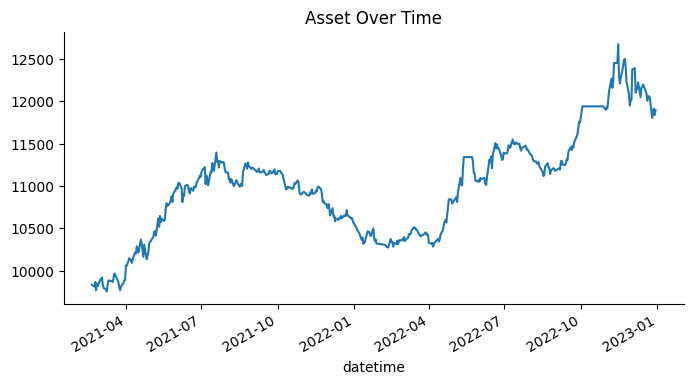

In [ ]:
# Plot asset value over time
data['Asset'].plot(kind='line', figsize=(8, 4), title='Asset Over Time')
plt.gca().spines[['top', 'right']].set_visible(False)

### 4.2 Holding Period Return

We can also calculate the rate of return during the considered period

In [ ]:
def holding_period_return(data: pd.DataFrame) -> float:
    cur_asset_value = data['Asset'].iloc[-1]
    init_asset_value = data['Asset'].iloc[0]

    return (cur_asset_value / init_asset_value - 1) * 100

In [ ]:
# Show the return of the period
print(accum_return_rate)

21.01034287737058


Holding Period Return: 21.01%
Holding Period: từ 2021-02-19 00:00:00 đến 2022-12-30 00:00:00


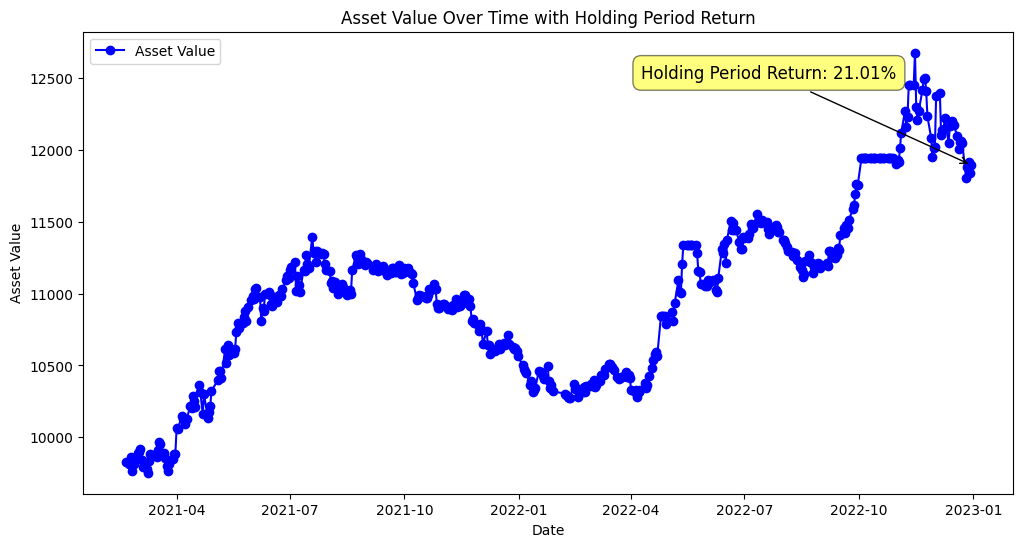

In [ ]:
# Lấy ngày đầu và ngày cuối của DataFrame (giả sử index là kiểu datetime)
init_date = data.index[0]
cur_date = data.index[-1]

# Tính giá trị hiện tại và ban đầu của tài sản
cur_asset_value = data['Asset'].iloc[-1]
init_asset_value = data['Asset'].iloc[0]

# Tính tỷ suất lợi nhuận tích lũy (Holding Period Return) theo %
accum_return_rate = (cur_asset_value / init_asset_value - 1) * 100

# In kết quả để kiểm tra
print(f"Holding Period Return: {accum_return_rate:.2f}%")
print(f"Holding Period: từ {init_date} đến {cur_date}")

# Vẽ biểu đồ giá trị tài sản theo thời gian
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Asset'], label='Asset Value', color='blue', marker='o')
plt.xlabel('Date')
plt.ylabel('Asset Value')
plt.title('Asset Value Over Time with Holding Period Return')

# Ghi chú Holding Period Return trên biểu đồ, tại vị trí cuối của đồ thị
plt.annotate(f"Holding Period Return: {accum_return_rate:.2f}%",
             xy=(data.index[-1], cur_asset_value),
             xytext=(0.6, 0.9), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             fontsize=12)

plt.legend()
plt.show()


### 4.3 Maximum Drawdown (MDD)

Maximum Drawdown (MDD) is also a great tool for assessing the maximum theoretical risk. We can calculate the MDD below.

In [ ]:
def mdd(data: pd.DataFrame) -> float:
    # For each day, calculate the peak of asset value since inception
    data['peak'] = data.apply(lambda row: data.loc[:row.name, 'Asset'].max(), axis=1)

    # For each day, calculate asset drawdown
    data['drawdown'] = data['Asset']/data['peak'] - 1

    # max drawdown is the most negative value
    return data['drawdown'].min() * 100

In [ ]:
# Show the MDD
print(mdd)

-9.84305727654704


Peak date: 2021-07-19 00:00:00
Trough date: 2022-02-11 00:00:00
MDD: -9.84305727654704 %


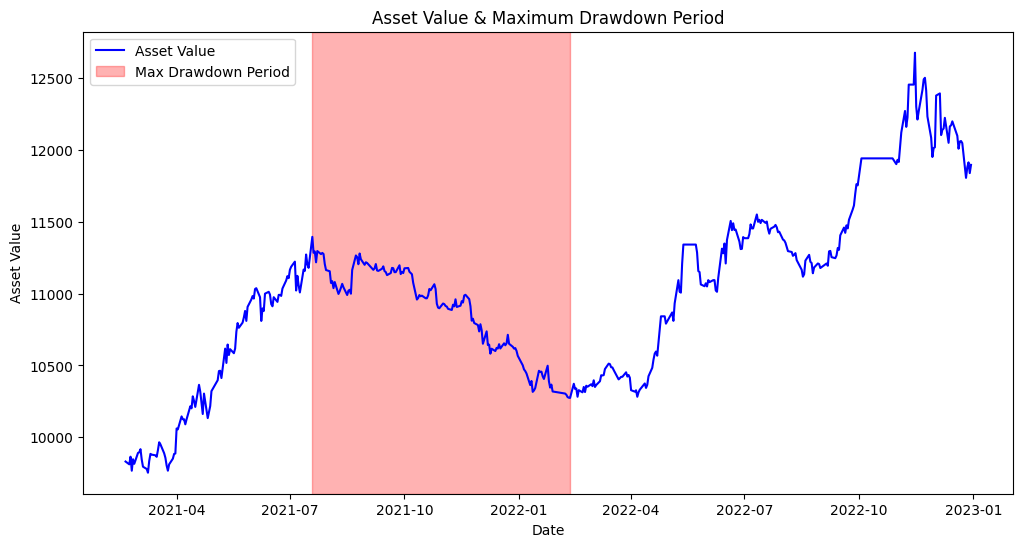

In [ ]:
# Giả sử dataframe của bạn đã có cột 'Asset', 'peak', 'drawdown'
# Xác định ngày trough (điểm thấp nhất của drawdown)
trough_date = data['drawdown'].idxmin()

# Xác định ngày peak (điểm cao nhất của asset cho tới trough_date)
peak_date = data.loc[:trough_date, 'Asset'].idxmax()

# In ra các giá trị để kiểm tra
print("Peak date:", peak_date)
print("Trough date:", trough_date)
print("MDD:", data['drawdown'].min() * 100, "%")

# Vẽ biểu đồ Asset Value và đánh dấu khoảng MDD
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Asset'], label='Asset Value', color='blue')
plt.axvspan(peak_date, trough_date, color='red', alpha=0.3, label='Max Drawdown Period')
plt.xlabel('Date')
plt.ylabel('Asset Value')
plt.title('Asset Value & Maximum Drawdown Period')
plt.legend()
plt.show()


### 4.4 Sharpe ratio

In the lecture, we have shown that the `Sharpe Ratio` is also a great tool to evaluate the compromising between reward and risk. We show the `Sharpe Ratio` of the SMA Trading algorithm in this section.

First we need to calculate the daily return

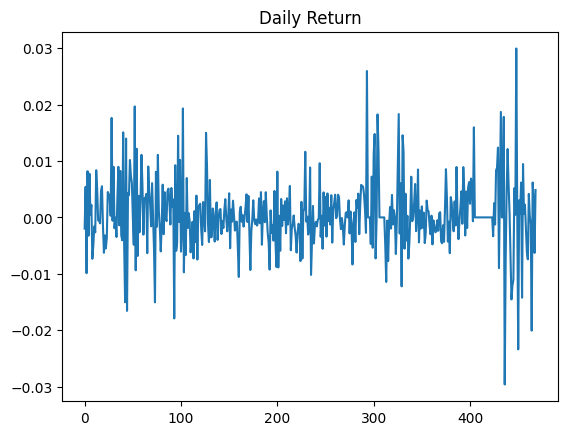

In [ ]:
# Compute the
daily_return = data['Asset'][1:].to_numpy() / data['Asset'][:-1].to_numpy() - 1

# plot daily return
x = list(range(len(daily_return)))
plt.plot(x, daily_return)
plt.title(label="Daily Return")
plt.show()

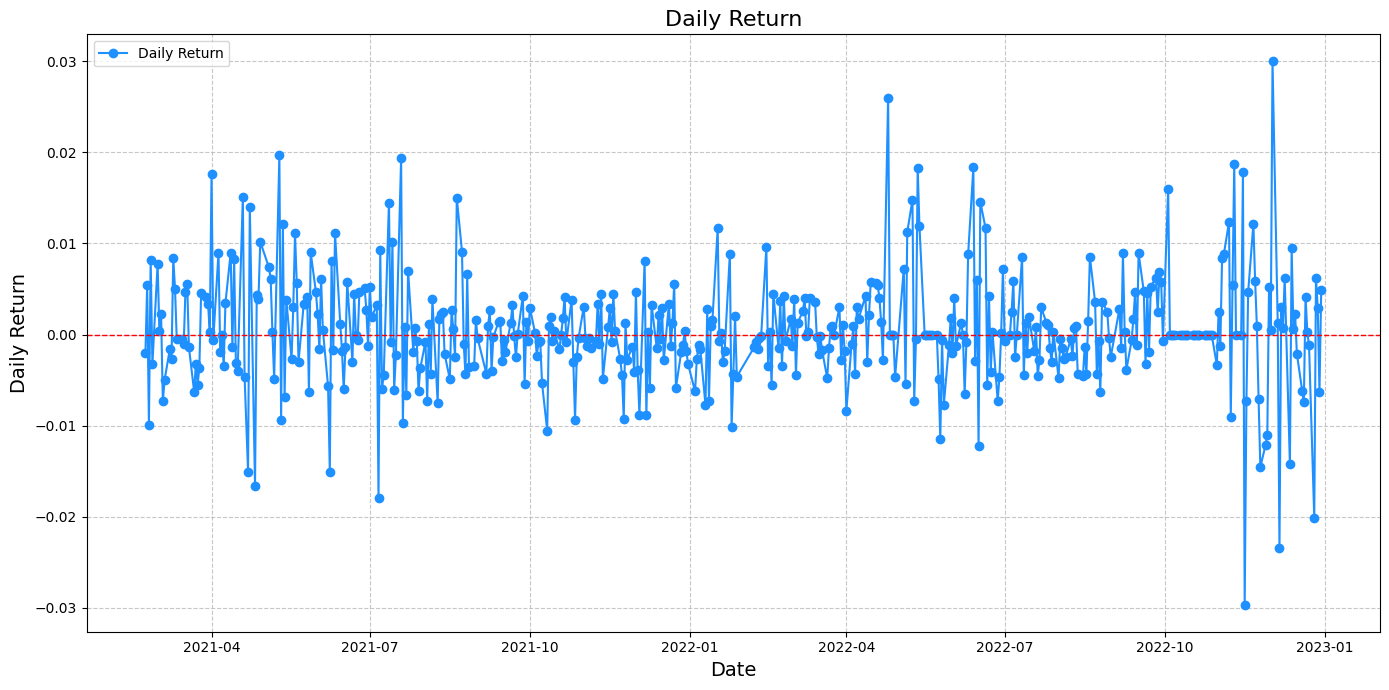

In [ ]:
# Tính daily return sử dụng hàm pct_change (dễ đọc và hiệu quả)
daily_return = data['Asset'].pct_change().dropna()

# Vẽ biểu đồ daily return với các cải tiến:
plt.figure(figsize=(14, 7))
plt.plot(data.index[1:], daily_return, marker='o', linestyle='-', color='dodgerblue', label='Daily Return')
plt.axhline(0, color='red', linewidth=1, linestyle='--')  # Đường ngang tại 0
plt.title("Daily Return", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Daily Return", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The daily return can be used to calculate the `Sharpe Ratio`. Since `Sharpe Ratio` is often used in the context of annual return, we need to annualize the `Sharpe Ratio` calculate through the daily return data.

In [ ]:
# Calculate the Sharpe Ratio by daily return with annualization
trading_days_per_year = 252
risk_free_rate = 0.03 # e.g. government bonds interest is 3% per year

# annual standard deviation
annual_std = np.sqrt(252) * np.std(daily_return)

print(annual_std)

# annual return
annual_return = 252 * np.mean(daily_return) - risk_free_rate

print(252 * np.mean(daily_return))
print(annual_return)

# annualized Sharpe ratio
sharpe = annual_return / annual_std

0.09795020072030591
0.1072797731020136
0.0772797731020136


In [ ]:
# Show the Sharpe Ration)
print(sharpe)

0.7889700330751118


Annualized Sharpe Ratio: 0.79


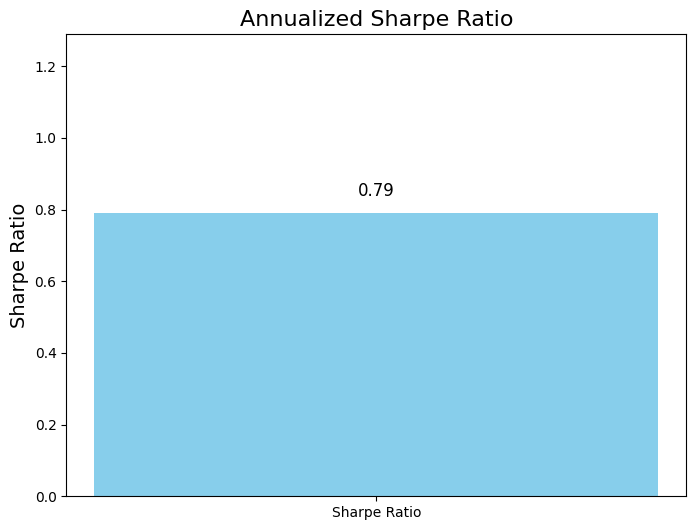

In [ ]:
# Giả sử bạn đã có daily_return, ví dụ như:
# daily_return = data['Asset'].pct_change().dropna()

# Các tham số
trading_days_per_year = 252
risk_free_rate = 0.03  # lãi suất phi rủi ro, 3%/năm

# Tính toán độ lệch chuẩn hàng năm và lợi nhuận hàng năm
annual_std = np.sqrt(trading_days_per_year) * np.std(daily_return)
annual_return = trading_days_per_year * np.mean(daily_return) - risk_free_rate

# Tính Sharpe Ratio hàng năm
sharpe = annual_return / annual_std

# In kết quả
print(f"Annualized Sharpe Ratio: {sharpe:.2f}")

# Trực quan hóa Sharpe Ratio bằng biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar("Sharpe Ratio", sharpe, color='skyblue')
plt.ylabel("Sharpe Ratio", fontsize=14)
plt.title("Annualized Sharpe Ratio", fontsize=16)
plt.ylim(0, max(1, sharpe + 0.5))
plt.text(0, sharpe + 0.05, f"{sharpe:.2f}", ha="center", fontsize=12)
plt.show()


Finally, we can show the information of SMA Trading Algorithm below

In [ ]:
print(
f"""
SMA window length: {SMA_WINDOW_LENGTH},
Take Profit threshold: {TAKE_PROFIT_THRES},
Cut Lost threshold: {CUT_LOSS_THRES},
Accumulate Rate: {accum_return_rate},
MDD: {mdd},
Sharpe Ratio: {sharpe}
"""
)


SMA window length: 30,
Take Profit threshold: 10,
Cut Lost threshold: -3,
Accumulate Rate: 21.01034287737058,
MDD: -9.84305727654704,
Sharpe Ratio: 0.7889700330751118

